# Application 6: Narde

After trained the models we can apply them to the real fragments.

In [3]:
%watermark -a "Lorenzo Cardarelli" -iv -v -m

Author: Lorenzo Cardarelli

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 151 Stepping 2, GenuineIntel
CPU cores   : 20
Architecture: 64bit

seaborn    : 0.12.2
torchvision: 0.15.2+cu118
matplotlib : 3.7.1
cv2        : 4.8.0
PIL        : 9.5.0
torch      : 2.0.1+cu118
scipy      : 1.11.3
skimage    : 0.21.0
pandas     : 2.0.2
numpy      : 1.24.3



## Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import rescale, resize, downscale_local_mean

# pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.optim as optim


# training and utils imports
from sklearn.model_selection import train_test_split
from torchinfo import summary
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import r2_score
from tqdm import tqdm

from utils import *
from models import *
from dataset import *

Move computation to GPU if available.

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
define_reproducibility(0)

Reproducibility is set to 0.


## Prepare data

In [32]:
pots = load_pots('narde.npz').reshape(-1, 256, 256)

In [33]:
tabular_data = pd.read_excel('selected_info_new_dataset.xlsx')
tabular_data_narde = pd.read_excel("selected_info_narde.xlsx")

In [34]:
encoders = fit_and_transform_encoders(tabular_data, ["Functional_class", "Morphology"])
transformed_data = transform_data_using_encoders(tabular_data_narde[["Functional_class","Morphology"]], encoders)

## Fine-tuning step

In this step we fine-tune the model on the single context.

### Hyperparameters

In [35]:
BATCH_SIZE = 60
EPOCHS = 50
LEARNING_RATE = 0.001
IMG_SIZE = 128
LATENT_DIMS = 100
CATEGORICAL_FEATURES = transformed_data.shape[1]

In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE, antialias=True),
    transforms.GaussianBlur(3),
    transforms.RandomRotation(5),
    transforms.RandomAffine(0, (0.01,0.01))
    ])

### Load all the models and weights

In [37]:
pretrained_model = CustomModel(num_classes=transformed_data.shape[1]).to(device)
pretrained_model.load_state_dict(torch.load("regressor_model.pth"))

<All keys matched successfully>

In [38]:
vae = reconstructionVAE(image_latent_dims=LATENT_DIMS).to(device)
vae.load_state_dict(torch.load('reconstructor_model.pth'))

<All keys matched successfully>

In [39]:
dae = DenoisingAutoencoder(latent_dims=LATENT_DIMS).to(device)
dae.load_state_dict(torch.load('denoiser_model.pth'))

<All keys matched successfully>

### Set up the models for fine-tuning

In [40]:
for param in pretrained_model.parameters():
    param.requires_grad = True

In [41]:
for param in vae.parameters():
    param.requires_grad = True

In [42]:
for param in dae.parameters():
    param.requires_grad = True

### Select data

In [43]:
selected_tabular = tabular_data_narde.loc[tabular_data_narde['context'] == "Narde"]

In [44]:
selected_tabular.head()

,index,ids,context,context_typology,wide_chronology,close_chronology,funeral_function,ID_context,Functional_interpretation,Morphology,Functional_class,manufacturing_technique,material,Grave,Pag.,Fig./Tav.,n.,ID_biblio
0,8811,NRD_0001,Narde,Funerary,FBA,FBA3,Cover,34,Tazza/Ciotola,Open shape,Class 2,Handmade,Impasto,183,327,103,5,5
1,8812,NRD_0002,Narde,Funerary,FBA,FBA1-2,Cover,34,Tazza/Ciotola,Open shape,Class 2,Handmade,Impasto,272,327,103,6,5
2,8813,NRD_0003,Narde,Funerary,FBA,FBA1-2,Cover,34,Scodella,Open shape,Class 1,Handmade,Impasto,470,337,113,4,5
3,8814,NRD_0004,Narde,Funerary,FBA,FBA1-2,Cover,34,Scodella,Open shape,Class 1,Handmade,Impasto,470,337,113,5,5
4,8815,NRD_0005,Narde,Funerary,FBA,FBA1-2,Cover,34,Scodella,Open shape,Class 1,Handmade,Impasto,77,338,114,1,5


Select also the tabular data

In [17]:
transformed_data_selected = transformed_data.loc[selected_tabular.index]

### Train and test split

In [18]:
test_size = 0.2

num_samples = len(selected_tabular)
num_samples_test = int(test_size * num_samples)


indices = list(range(num_samples))
indices_train, indices_test = train_test_split(indices, test_size=test_size, random_state=42)


pots_train = pots[selected_tabular.index][indices_train]
functional_encoded_train = transformed_data_selected.values[indices_train]

pots_test = pots[selected_tabular.index][indices_test]
functional_encoded_test = transformed_data_selected.values[indices_test]

### Prepare data for the model

In [19]:
pots_pytorch_trn = PotTorch(pots_train, functional_encoded_train, 
                            transform=transform, img_size=IMG_SIZE)

pots_pytorch_tst = PotTorch(pots_test, functional_encoded_test, 
                            transform=transform, img_size=IMG_SIZE)

In [20]:
data_loader_train = DataLoader(dataset = pots_pytorch_trn, batch_size=BATCH_SIZE, 
                               shuffle=True, drop_last=True)

data_loader_test = DataLoader(dataset = pots_pytorch_tst, batch_size=BATCH_SIZE, 
                              shuffle=True, drop_last=True)

In [21]:
pot, masked_img, padded_tensor, bounding_box, scale_factor, archeo_info, mask, x_filled = next(iter(data_loader_train))

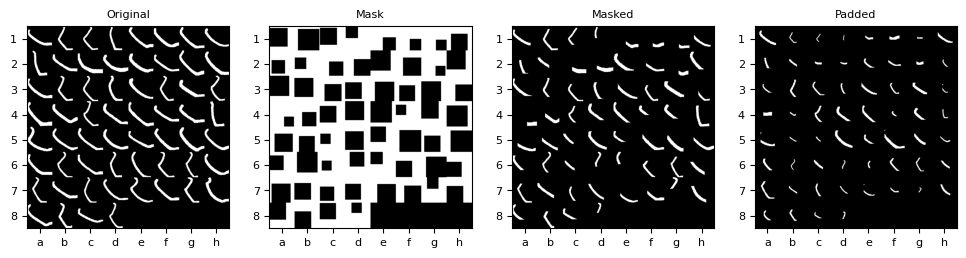

In [22]:
plot_batches([pot, mask, masked_img, padded_tensor], 
             title_list=["Original", "Mask", "Masked", "Padded"], 
             figsize=(12, 8), nrow=8, title_size=8, tick_size=8)

### Regression step

In [23]:
fine_tuned_regressor = RegressorFineTuner(pretrained_model, 
                                          25, 
                                          data_loader_train, 
                                          data_loader_test, 
                                          lr=0.0005, 
                                          BATCH_SIZE=BATCH_SIZE, 
                                          device=device) 

Training Progress:   4%|▍         | 1/25 [00:08<03:15,  8.16s/it]

Epoch [1/25] - Training Loss: 0.0119 - Testing Loss: 0.0098


Training Progress:  24%|██▍       | 6/25 [00:39<02:00,  6.35s/it]

Epoch [6/25] - Training Loss: 0.0038 - Testing Loss: 0.0031


Training Progress:  44%|████▍     | 11/25 [01:10<01:26,  6.20s/it]

Epoch [11/25] - Training Loss: 0.0032 - Testing Loss: 0.0037


Training Progress:  64%|██████▍   | 16/25 [01:42<00:59,  6.65s/it]

Epoch [16/25] - Training Loss: 0.0032 - Testing Loss: 0.0031


Training Progress:  84%|████████▍ | 21/25 [02:13<00:24,  6.21s/it]

Epoch [21/25] - Training Loss: 0.0027 - Testing Loss: 0.0025


Training Progress: 100%|██████████| 25/25 [02:38<00:00,  6.33s/it]


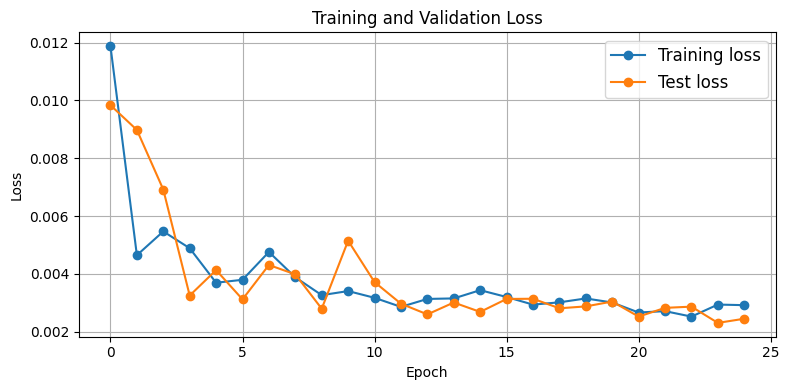

In [24]:
fine_tuned_regressor.plot_losses()

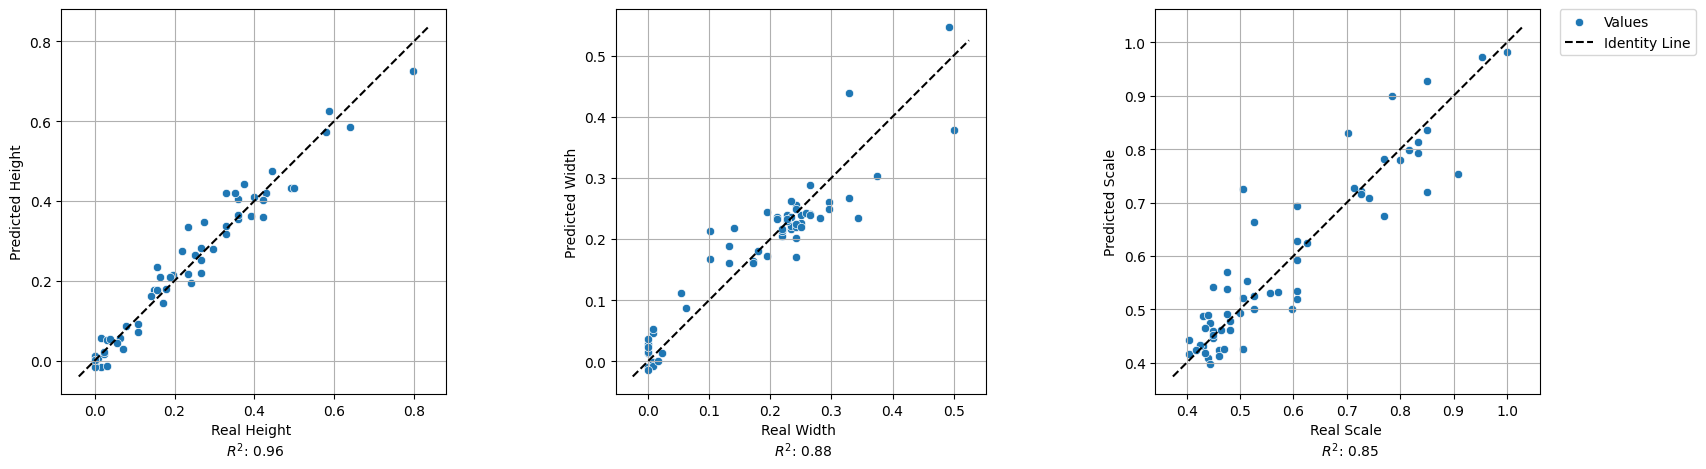

In [25]:
fine_tuned_regressor.r_square_plot()

## Denoising step

In [26]:
dae_fine_tuned = DAEFineTuner(dae, 
                              25, 
                              data_loader_train, 
                              data_loader_test, 
                              mask_weight=0.2, 
                              lr=0.0005, 
                              BATCH_SIZE=BATCH_SIZE, 
                              device=device)

Training Progress:   4%|▍         | 1/25 [00:06<02:35,  6.46s/it]

Epoch [1/25] - Training Loss: 6918.4606 - Testing Loss: 8871.2822


Training Progress:  24%|██▍       | 6/25 [00:36<01:55,  6.08s/it]

Epoch [6/25] - Training Loss: 3806.5223 - Testing Loss: 3560.1162


Training Progress:  44%|████▍     | 11/25 [01:04<01:17,  5.53s/it]

Epoch [11/25] - Training Loss: 3362.8643 - Testing Loss: 3155.8784


Training Progress:  64%|██████▍   | 16/25 [01:31<00:49,  5.55s/it]

Epoch [16/25] - Training Loss: 3339.4890 - Testing Loss: 3171.3728


Training Progress:  84%|████████▍ | 21/25 [02:00<00:23,  5.82s/it]

Epoch [21/25] - Training Loss: 3258.0819 - Testing Loss: 3226.6582


Training Progress: 100%|██████████| 25/25 [02:24<00:00,  5.77s/it]


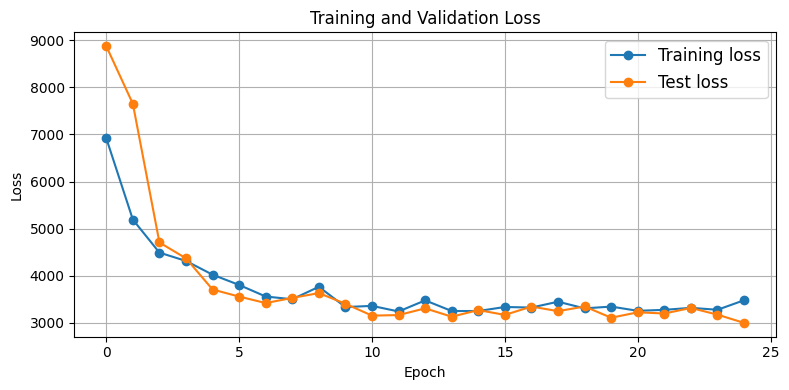

In [27]:
dae_fine_tuned.plot_losses()

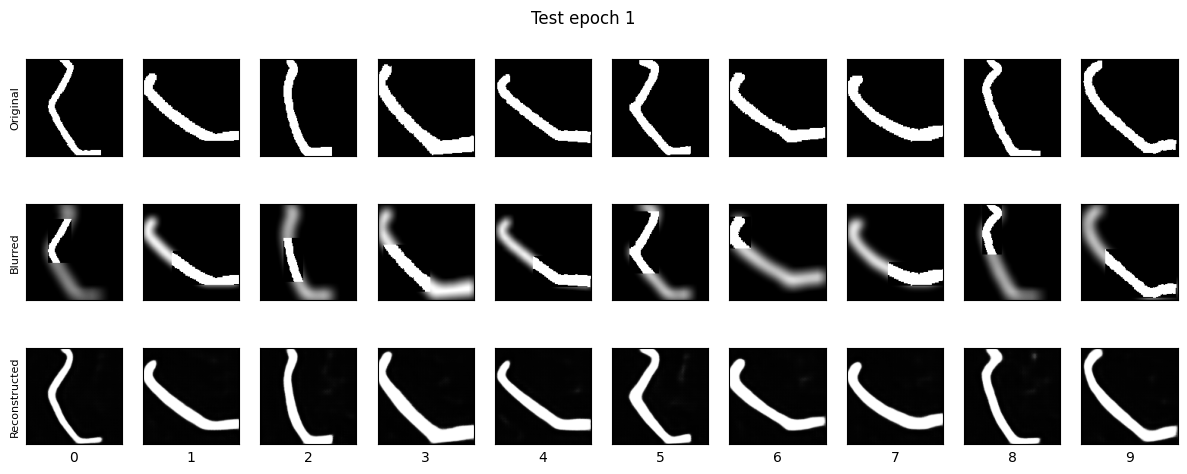

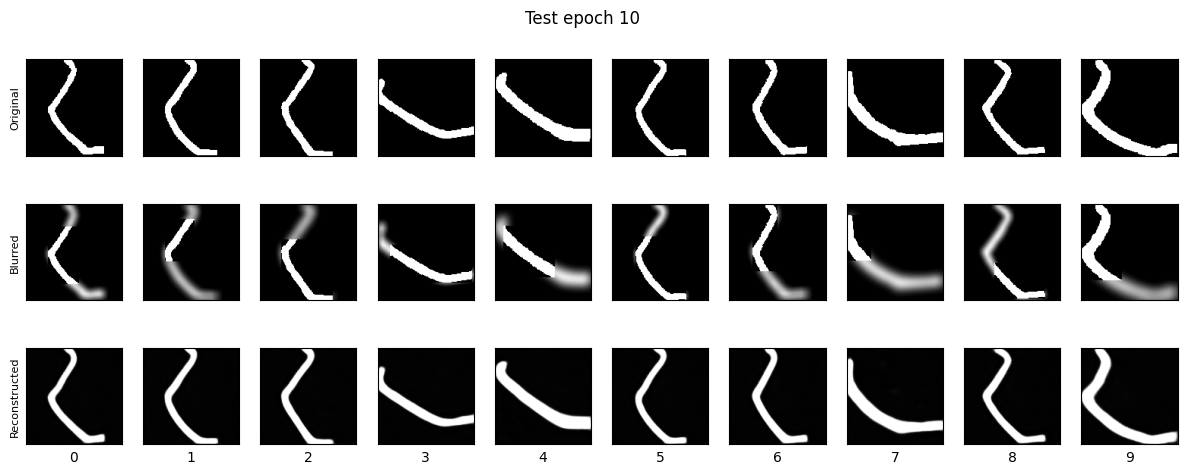

In [28]:
dae_fine_tuned.plot_outputs([0, 9], output_set="test")

### Reconstruction step

In [29]:
vae_fine_tuned = VAEFineTuner(vae, 
                              25, 
                              data_loader_train, 
                              data_loader_test, 
                              loss="MSE", 
                              mask_weight=0.2, 
                              lr=0.0005, 
                              BATCH_SIZE=BATCH_SIZE, 
                              device=device)

Training Progress:   4%|▍         | 1/25 [00:06<02:24,  6.01s/it]

Epoch [1/25] - Training Loss: 18737.3511 - Testing Loss: 17217.2852


Training Progress:  24%|██▍       | 6/25 [00:32<01:38,  5.18s/it]

Epoch [6/25] - Training Loss: 13844.4680 - Testing Loss: 13904.0615


Training Progress:  44%|████▍     | 11/25 [00:56<01:07,  4.85s/it]

Epoch [11/25] - Training Loss: 13204.3757 - Testing Loss: 15287.5479


Training Progress:  64%|██████▍   | 16/25 [01:21<00:44,  4.91s/it]

Epoch [16/25] - Training Loss: 13278.0808 - Testing Loss: 14995.3701


Training Progress:  84%|████████▍ | 21/25 [01:44<00:18,  4.51s/it]

Epoch [21/25] - Training Loss: 12445.3413 - Testing Loss: 12918.2041


Training Progress: 100%|██████████| 25/25 [02:06<00:00,  5.07s/it]


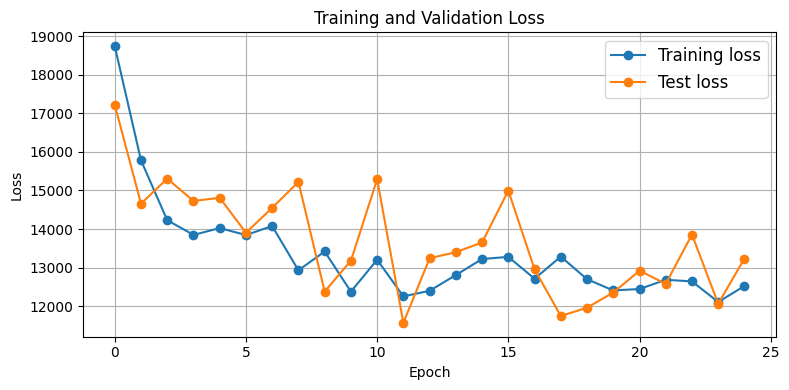

In [30]:
vae_fine_tuned.plot_losses()

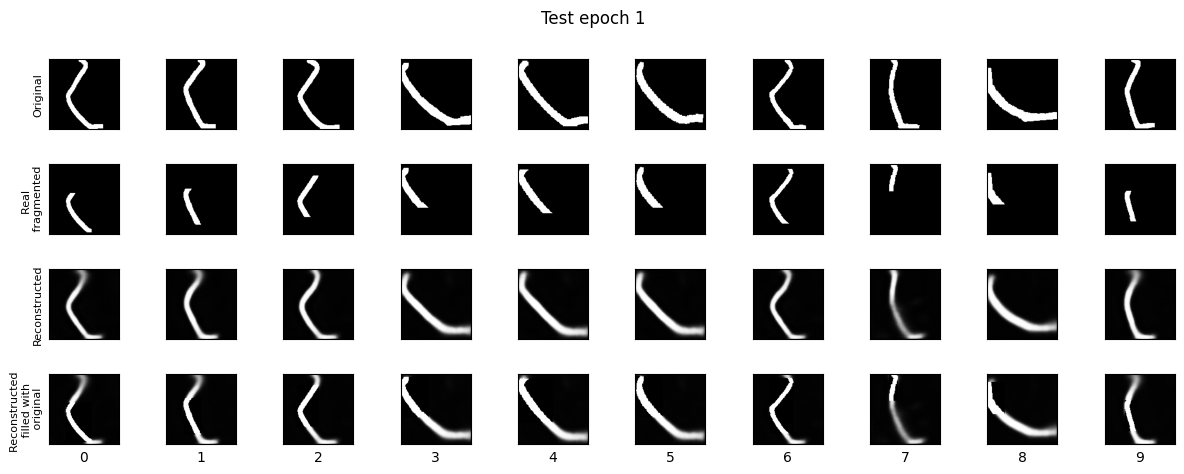

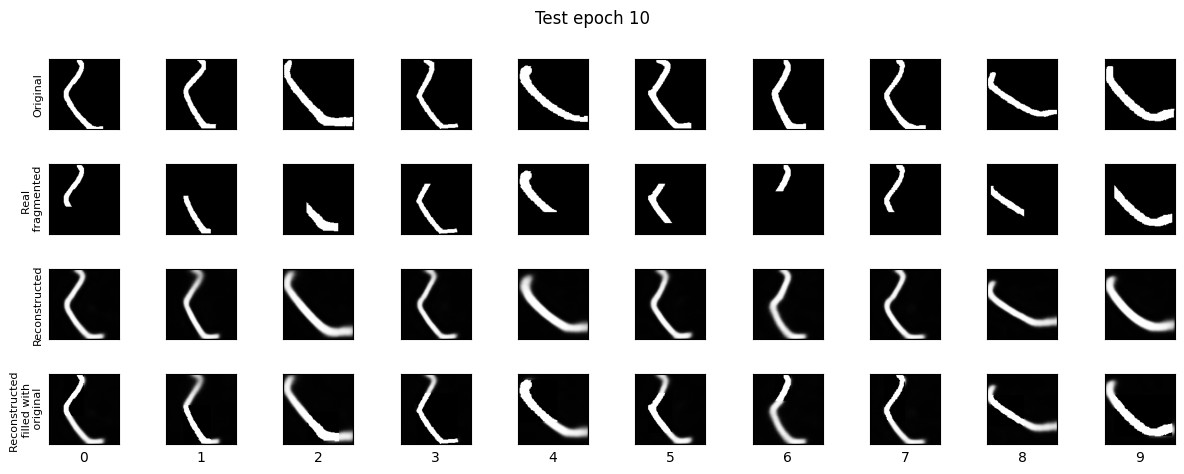

In [31]:
vae_fine_tuned.plot_outputs([0, 9], output_set="test")

## Application to actual framgents

In [32]:
# Import some additional libraries

import os
from pathlib import Path
from PIL import Image

Read the fragment images

In [33]:
imgs_frag = read_and_denoise_imgs(r"materials_frag\NRD_frag")

Read the tabular data associated to the fragments

In [34]:
info_fragments = pd.read_excel(r"materials_frag\fragments.xlsx")

Select the context's fragments

In [35]:
info_fragments_selected = info_fragments[info_fragments["context"].isin(["Narde"])].reset_index(drop=True)

info_fragments_selected = info_fragments_selected.loc[info_fragments_selected.Functional_class.dropna().index]

Transform the labels according to the model

In [36]:
transformed_data = transform_data_using_encoders(info_fragments_selected[["Functional_class", "Morphology"]], encoders) #"Functional_class"

Select images according to the tabular information

In [37]:
imgs_frag = imgs_frag[info_fragments_selected.index]

Define some transformations (no augmentation)

In [38]:
transform_rec = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE, antialias=True),
    ])

And define a PotTorch dataset, similiar to the one used for training

In [39]:
potds_pytorch_real_frag = PotTorch(imgs_frag, transformed_data.values, transform=transform_rec, img_size=IMG_SIZE)

Define a batch size. If the dataset is too big, it can be divided in batches. A batch can contain a limit of 128 images, like in the training phase.

In [40]:
if len(imgs_frag) <= 128:
    batch_size = len(imgs_frag)
else:
    batch_size = 128 # or specify the batch size you want here


Create a dataloader

In [41]:
data_loader_real_frag = DataLoader(dataset = potds_pytorch_real_frag, batch_size=batch_size, shuffle=False, drop_last=False)

Using a custom function, we can apply the *Regressor* to the images. The function will return a folder with the predicted positions, that can be used to verify the results.

In [52]:
#predict_fragments(data_loader_real_frag, pretrained_model, batch_size, context_name = "NRD", df_ids=info_fragments_selected)

Once the positions are checked, we can continue with the reconstruction step.

In [115]:
files_path= read_img_files(r"img_pos_NRD")

In [116]:
imgs_pos = []
for img_file in files_path:
    x = Image.open(img_file).convert("L")
    x = np.array(x)
    x = 255 - x
    x = denoise_and_binarize(x)
    imgs_pos.append(x)

In [117]:
imgs_pos = np.array(imgs_pos)

Create a new dataset and dataloader for the reconstruction step

In [118]:
potds_pytorch_real_frag = PotTorch(imgs_pos, transformed_data.values, transform=transform_rec, img_size=IMG_SIZE)

In [119]:
data_loader_real_frag = DataLoader(dataset = potds_pytorch_real_frag, batch_size=batch_size, shuffle=False, drop_last=False)

In [120]:
reconstructed_imgs = []
pot_list = []

for batch, (pot, _, _, _, _, archeo_info, _, _) in enumerate(data_loader_real_frag):

    pot = pot.to(device).float()
    archeo_info = archeo_info.to(device).float()

    encoded, z_mean, z_log_var, decoded = vae_fine_tuned.model(pot)

    reconstructed_imgs.append(decoded.detach().cpu())
    pot_list.append(pot.detach().cpu())

reconstructed_imgs = torch.cat(reconstructed_imgs, dim=0)
pot_list = torch.cat(pot_list, dim=0)

Create the "Reconstructed filled with original" images

In [121]:
row_mask = torch.all(torch.eq(pot_list, 0), dim=3, keepdim=True)
col_mask = torch.all(torch.eq(pot_list, 0), dim=2, keepdim=True)
x_filled = torch.where(row_mask, reconstructed_imgs, pot_list)
rec_filled = torch.where(col_mask, reconstructed_imgs, x_filled)

In [122]:
decoded_filled = rec_filled.to(device).float()
decoded = dae(decoded_filled)  

And visualise the results

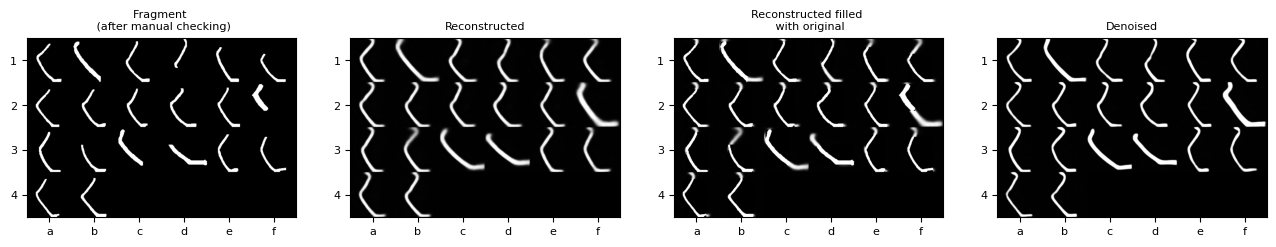

In [123]:
plot_batches([pot_list, reconstructed_imgs, rec_filled, decoded], 
             title_list=["Fragment \n (after manual checking)", "Reconstructed", "Reconstructed filled \n with original", "Denoised"], 
             figsize=(16, 10), nrow=6, title_size=8, tick_size=8, save_fig=True)

## Human evaluation

Evaluate the results of the reconstruction using a human evaluator.

### First approach. Discrimination between real and fake

In [124]:
from skimage.transform import resize
import random
from skimage.morphology import disk
from skimage.filters import median

from scipy.sparse import csr_matrix, save_npz

In [125]:
frag_decoded_numpy = decoded.cpu().detach().numpy()
frag_decoded_numpy = frag_decoded_numpy.squeeze(1)

Select real pots

In [126]:
pots_metrics = pots[selected_tabular.index]

In [127]:
pots_metrics_rescaled = []
for pot in pots_metrics:
    x = resize(pot, (128, 128), anti_aliasing=False)
    pots_metrics_rescaled.append(x)

pots_metrics_rescaled = np.array(pots_metrics_rescaled)

In [128]:
pots_metrics_rescaled.shape

(306, 128, 128)

Select a number of original images equal to the number of the reconstructed images

In [129]:
selected_index = np.random.choice(np.arange(len(pots_metrics)), len(frag_decoded_numpy), replace=False)

In [130]:
frag_decoded_numpy_list  = []
for i in range(len(frag_decoded_numpy)):
    x = denoise_and_binarize(frag_decoded_numpy[i])
    
    min_img = minimum_image(x, margin=2)
    postprocessed = pad_image_postprocessing(min_img, 128)
    resized = resize(postprocessed, (128, 128), anti_aliasing=False)

    frag_decoded_numpy_list.append(resized)
    

frag_decoded_numpy_noised = np.array(frag_decoded_numpy_list)

In [131]:
decoded_real_numpy = np.array([median(img, disk(1)) for img in pots_metrics_rescaled[selected_index]])

frag_decoded_numpy = np.array([median(img, disk(2)) for img in frag_decoded_numpy_noised])

Concatenate the original images and the reconstructed images

In [132]:
stacked = np.vstack((frag_decoded_numpy, decoded_real_numpy))

Create a dataframe containing the images

In [133]:
df_res = pd.DataFrame(range(0, len(stacked)), columns=["ID_real"])
df_res["type"] = ["reconstructed"] * len(frag_decoded_numpy) + ["real"] * len(decoded_real_numpy)
stacked_flatten = stacked.reshape(stacked.shape[0], -1)

### Add the images to the dataframe
df_res["img"] = [img for img in stacked_flatten]

id_df_shuffle =df_res.ID_real.values.copy()

random.shuffle(id_df_shuffle)

### Set the shuffled IDs
df_res["ID_shuffle"] = id_df_shuffle
df_res.sort_values(by="ID_shuffle", inplace=True)
df_res.set_index("ID_shuffle", inplace=True)
df_res.reset_index(inplace = True)

df_res.to_excel("HE/NRD/reconstructed_real_nrd.xlsx", index=True)

df_res.reset_index(inplace=True)

In [134]:
reordered_array = []
for i, row in df_res.iterrows():
    reordered_array.append(stacked_flatten[row.ID_real])

reordered_array = np.array(reordered_array)

Save the images

In [135]:
save_npz("HE/NRD/first_eval_nrd.npz", csr_matrix(reordered_array))

In [136]:
#pdf_filename = "output_first_eval_trrgll.pdf"

#create_pdf_first_eval(df_res, pdf_filename, id_df =df_res.index,  images_per_page=12)


### Second approach. Archaelogical features evaluation

In [137]:
pot_list_numpy = pot_list.cpu().detach().numpy()
decoded_numpy = decoded.cpu().detach().numpy()

pot_list_numpy = pot_list_numpy.squeeze(1)
decoded_numpy = decoded_numpy.squeeze(1)

In [138]:
decoded_numpy_list  = []
for i in range(len(decoded_numpy)):
    x = denoise_and_binarize(decoded_numpy[i])
    min_img = minimum_image(x, margin=2)
    postprocessed = pad_image_postprocessing(min_img, 128)
    resized = resize(postprocessed, (128, 128), anti_aliasing=False)

    decoded_numpy_list.append(resized)

decoded_numpy = np.array(decoded_numpy_list)

In [139]:
pdf_filename = "output_second_eval_nrd.pdf"
create_pdf_second_eval(pot_list_numpy, decoded_numpy, pdf_filename, id_df=df_res.index, images_per_page=10)